In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities import utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Analytics on model predictions

In [2]:
query = '''
    select
        model_id
      , avg(abs_error) as mean_absolute_error
      , 100 * sum(n_loss) / count(*) as loss_rate
    from dbt.evaluation
    group by model_id
    order by model_id
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,mean_absolute_error,loss_rate
0,s1,0.097680,25
1,s2,0.097618,25
2,s3,0.103816,18
3,s4,0.094706,28


In [3]:
query = '''
    select *
    from dbt.evaluation
    order by model_id, symbol, market_datetime
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,market_datetime,symbol,sector,industry,target,prediction,error,abs_error,is_loss,n_loss,mean_error_10,mean_error_30,mean_error_60,mean_error_90,max_error_10,max_error_30,max_error_60,max_error_90
0,s1,2019-02-01,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,64.588459,-0.139624,0.139624,False,0,0.139624,0.139624,0.139624,0.139624,0.139624,0.139624,0.139624,0.139624
1,s1,2019-02-04,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,64.412210,-0.141971,0.141971,False,0,0.140797,0.140797,0.140797,0.140797,0.141971,0.141971,0.141971,0.141971
2,s1,2019-02-05,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,64.051585,-0.146775,0.146775,False,0,0.142790,0.142790,0.142790,0.142790,0.146775,0.146775,0.146775,0.146775
3,s1,2019-02-06,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,63.791666,-0.150238,0.150238,False,0,0.144652,0.144652,0.144652,0.144652,0.150238,0.150238,0.150238,0.150238
4,s1,2019-02-07,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,75.07,63.695270,-0.151522,0.151522,False,0,0.146026,0.146026,0.146026,0.146026,0.151522,0.151522,0.151522,0.151522
5,s1,2019-02-08,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,76.00,63.863061,-0.159697,0.159697,False,0,0.148304,0.148304,0.148304,0.148304,0.159697,0.159697,0.159697,0.159697
6,s1,2019-02-11,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,76.80,64.867430,-0.155372,0.155372,False,0,0.149314,0.149314,0.149314,0.149314,0.159697,0.159697,0.159697,0.159697
7,s1,2019-02-12,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,77.00,65.690583,-0.146876,0.146876,False,0,0.149009,0.149009,0.149009,0.149009,0.159697,0.159697,0.159697,0.159697
8,s1,2019-02-13,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,77.00,65.506397,-0.149268,0.149268,False,0,0.149038,0.149038,0.149038,0.149038,0.159697,0.159697,0.159697,0.159697
9,s1,2019-02-14,A,Capital Goods,Biotechnology: Laboratory Analytical Instruments,77.53,65.301500,-0.157726,0.157726,False,0,0.149907,0.149907,0.149907,0.149907,0.159697,0.159697,0.159697,0.159697


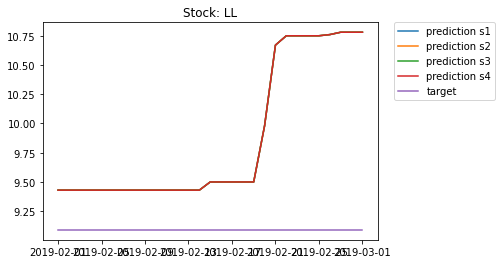

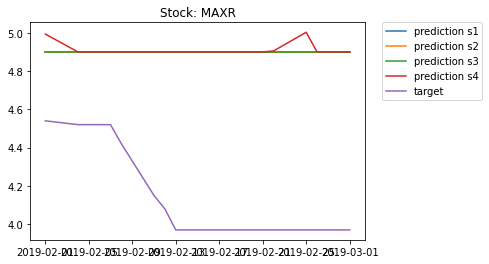

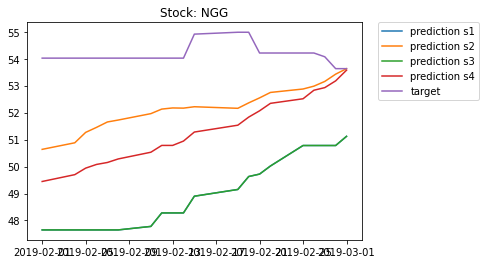

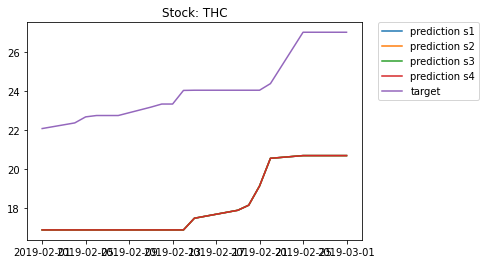

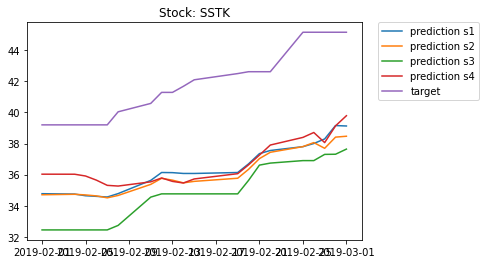

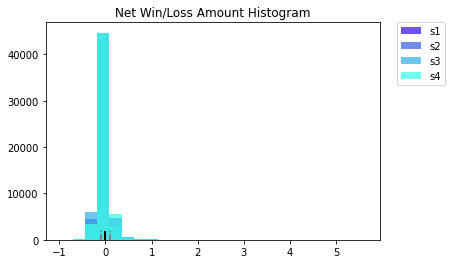

In [4]:
stocks = np.random.choice(df['symbol'].unique(), 5)
models = np.sort(df['model_id'].unique())
for s in stocks:
    temp = df[df['symbol']==s]
    for m in models:
        x = temp[temp['model_id']==m]
        plt.title(f'Stock: {s}')
        plt.plot(x['market_datetime'], x['prediction'], label=f'prediction {m}')
    plt.plot(x['market_datetime'], x['target'], label='target')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

color_offset = 0.1
for m in models:
    temp = df[df['model_id']==m]
    plt.title(f'Net Win/Loss Amount Histogram')
    plt.hist(temp['error'], bins=25, ls='dashed', lw=2, fc=(.25, color_offset, .9, .75), label=m)
    plt.vlines(-.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
    plt.vlines(0, ymin=0, ymax=2000, color='black')
    plt.vlines(.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    color_offset += .3
plt.show()

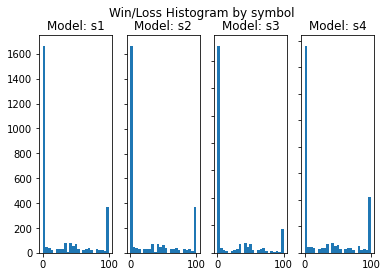

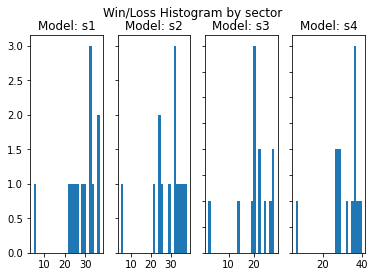

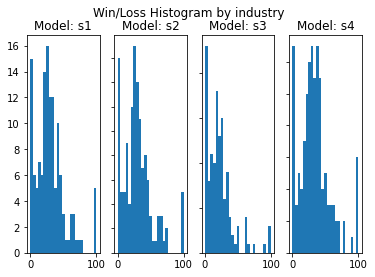

In [5]:
def groupby_plot(
    group
):
    query = f'''
        select
            model_id
          , {group}
          , 100 * sum(n_loss) / count(*) as loss_rate
        from dbt.evaluation
        group by 1,2
        '''
    df = utils.query_db(query=query)
    df.head(10)

    models = np.sort(df['model_id'].unique())
    n = len(models)

    fig, axs = plt.subplots(1, n)
    fig.suptitle(f'Win/Loss Histogram by {group}')
    for m in range(0, n):
        model = models[m]
        axs[m].set_title(f'Model: {model}')
        axs[m].hist(df.loc[df['model_id']==model, 'loss_rate'], bins=25)

    for ax in axs.flat:
        ax.label_outer()

    plt.show()

groupby_plot('symbol')
groupby_plot('sector')
groupby_plot('industry')

In [6]:
query = '''
    with
    s as (
    select distinct
        market_datetime::date
      , open / lag(open) over (order by market_datetime) as sp_open
    from yahoo.sp_index
    )
    select
        e.model_id
      , e.market_datetime
      , s.sp_open 
      , 100 * sum(e.n_loss) / count(*) as loss_rate
      , max(e.abs_error) as largest_daily_abs_error
      , avg(e.abs_error) as avg_abs_error
    from dbt.evaluation as e
    left join s
      on e.market_datetime = s.market_datetime
    group by 1,2,3
    order by 1,2,3
    '''
df = utils.query_db(query=query)
df.head(10)

,model_id,market_datetime,sp_open,loss_rate,largest_daily_abs_error,avg_abs_error
0,s1,2019-02-01,1.006267,17,1.515876,0.108770
1,s1,2019-02-04,1.001543,18,1.526076,0.109807
2,s1,2019-02-05,1.008073,18,1.830769,0.110700
3,s1,2019-02-06,1.002459,18,1.919708,0.111108
4,s1,2019-02-07,0.993594,19,1.919708,0.111194
5,s1,2019-02-08,0.990738,18,1.919708,0.110911
6,s1,2019-02-11,1.007443,19,3.504484,0.107137
7,s1,2019-02-12,1.003764,20,1.919708,0.103257
8,s1,2019-02-13,1.010170,20,4.272206,0.102870
9,s1,2019-02-14,0.997528,21,5.164154,0.104295


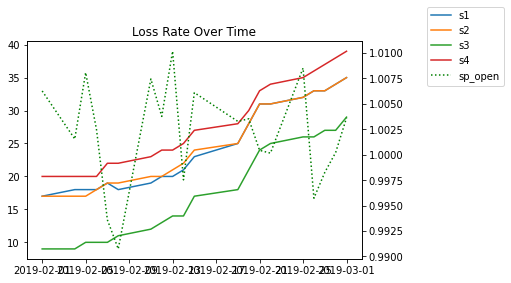

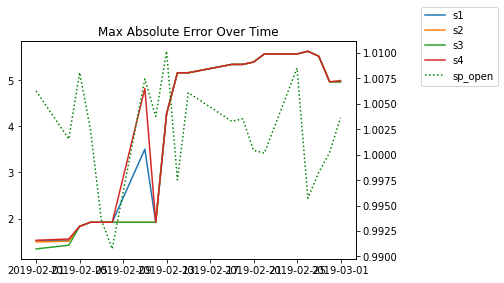

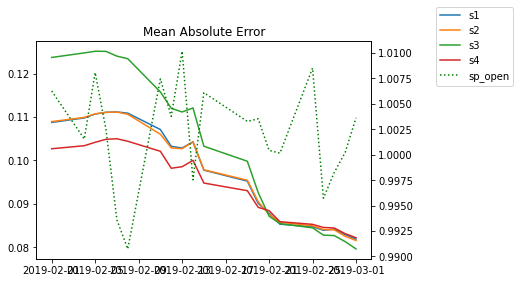

In [7]:
def multiplot(
    title,
    column,
):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    models = np.sort(df['model_id'].unique())
    for m in models:
        x = df[df['model_id']==m]
        plt.title(title)
        ax1.plot(x['market_datetime'], x[column], label=m)
    ax2.plot(x['market_datetime'], x['sp_open'], label='sp_open', color='g', linestyle=':')
    fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

multiplot(
    title = 'Loss Rate Over Time',
    column = 'loss_rate',
)  

multiplot(
    title='Max Absolute Error Over Time',
    column='largest_daily_abs_error',
)

multiplot(
    title='Mean Absolute Error',
    column='avg_abs_error',
)